# Sep 15, 2025: test number of partitions required for stable number of modes

conda env: gt

In [1]:
import csv
import os
import sys
import numpy as np
import pandas as pd
import scipy as sp 
import dill as pickle 
from os.path import join as pjoin
from itertools import product
from tqdm import tqdm
from copy import deepcopy
from pathlib import Path
import subprocess
from scipy import sparse, stats
from multiprocessing import Pool
import glob
# import arviz as az
import random
import re
from tqdm import tqdm

from itertools import product, combinations
import multiprocessing as mp
from functools import partial
from concurrent.futures import ProcessPoolExecutor

from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics.pairwise import cosine_similarity
from munkres import Munkres

# networks
import graph_tool.all as gt

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow

plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import colorcet as cc

# ignore user warnings
import warnings
warnings.filterwarnings("ignore") #, category=UserWarning)

In [2]:
class ARGS():
    pass

args = ARGS()

args.SEED = 100

In [3]:
args.source = 'allen' #'spatial' #'allen'
args.space = 'ccfv2' #'ccfv2'
args.brain_div = 'whl' #'whl'
args.num_rois = 172 #162 #172
args.resolution = 200 #200

PARC_DESC = (
    f'source-{args.source}'
    f'_space-{args.space}'
    f'_braindiv-{args.brain_div}'
    f'_nrois-{args.num_rois}'
    f'_res-{args.resolution}'
)
PARC_DESC

'source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200'

In [4]:
args.GRAPH_DEF = f'constructed'
args.GRAPH_METHOD = f'pearson'
args.THRESHOLD = f'signed'
args.EDGE_DEF = f'binary'
args.EDGE_DENSITY = 20
args.LAYER_DEF = f'individual'
args.DATA_UNIT = f'grp'

BASE_path = f'{os.environ["HOME"]}/new_mouse_dataset'
PARCELS_path = f'{BASE_path}/parcels'
ROI_path = (
    f'{BASE_path}/roi-results-v3'
    f'/{PARC_DESC}'
)
TS_path = f'{ROI_path}/roi_timeseries'
ROI_RESULTS_path = (
    f'{ROI_path}'
    f'/graph-{args.GRAPH_DEF}/method-{args.GRAPH_METHOD}'
    f'/threshold-{args.THRESHOLD}/edge-{args.EDGE_DEF}/density-{args.EDGE_DENSITY}'
    f'/layer-{args.LAYER_DEF}/unit-{args.DATA_UNIT}'
)
GRAPH_path = f'{ROI_RESULTS_path}/graphs'
os.system(f'mkdir -p {GRAPH_path}')
SBM_path = f'{ROI_RESULTS_path}/model-fits'
os.system(f'mkdir -p {SBM_path}')
DIAG_path = f'{ROI_RESULTS_path}/diagnostics'
os.system(f'mkdir -p {DIAG_path}')
ESTIM_path = f'{ROI_RESULTS_path}/estimates'
os.system(f'mkdir -p {ESTIM_path}/individual')
os.system(f'mkdir -p {ESTIM_path}/group')

0

In [5]:
args.dc, args.sbm = False, 'h'
args.nested = args.sbm == 'h'

args.force_niter = 40000
args.num_draws = int((1/2) * args.force_niter)

args.epsilon = 0.4 # threshold KSD for convergence
args.delta = np.ceil(args.force_niter / 100).astype(int)

def sbm_name(args):
    dc = f'dc' if args.dc else f'nd'
    dc = f'' if args.sbm in ['a', 'm'] else dc
    file = f'sbm-{dc}-{args.sbm}'
    return file

SBM = sbm_name(args)
SBM

'sbm-nd-h'

In [6]:
gfile = sorted(glob.glob(f'{GRAPH_path}/*', recursive=True))[0]
g = gt.load_graph(gfile)
g

<Graph object, undirected, with 172 vertices and 2942 edges, 1 internal edge property, at 0x7f6afe8a57f0>

In [7]:
files = sorted(glob.glob(f'{ESTIM_path}/individual/sub-*/partition-modes/*{SBM}*_samples-*'))

In [8]:
files

['/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-constructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-grp/estimates/individual/sub-SLC01/partition-modes/sbm-nd-h_samples-10000_desc-df.pkl',
 '/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-constructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-grp/estimates/individual/sub-SLC01/partition-modes/sbm-nd-h_samples-1000_desc-df.pkl',
 '/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-constructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-grp/estimates/individual/sub-SLC01/partition-modes/sbm-nd-h_samples-100_desc-df.pkl',
 '/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-constructed/method-pears

In [9]:
def read_file(file):
    match = re.search(r'sbm-([^_]+)_samples-(\d+)', file)
    if match:
        sbm, samples = match.groups()

    with open(f'{file}', 'rb') as f:
        modes_df = pickle.load(f)

    modes_df['samples'] = [samples]*len(modes_df)
    cols = ['samples'] + [col for col in modes_df.columns if 'samples' not in col]
    modes_df = modes_df[cols]
    return modes_df

In [10]:
modes_dfs = []
for file in tqdm(files):
    modes_df = read_file(file)
    modes_dfs += [modes_df]

100%|██████████| 8/8 [13:21<00:00, 100.24s/it]


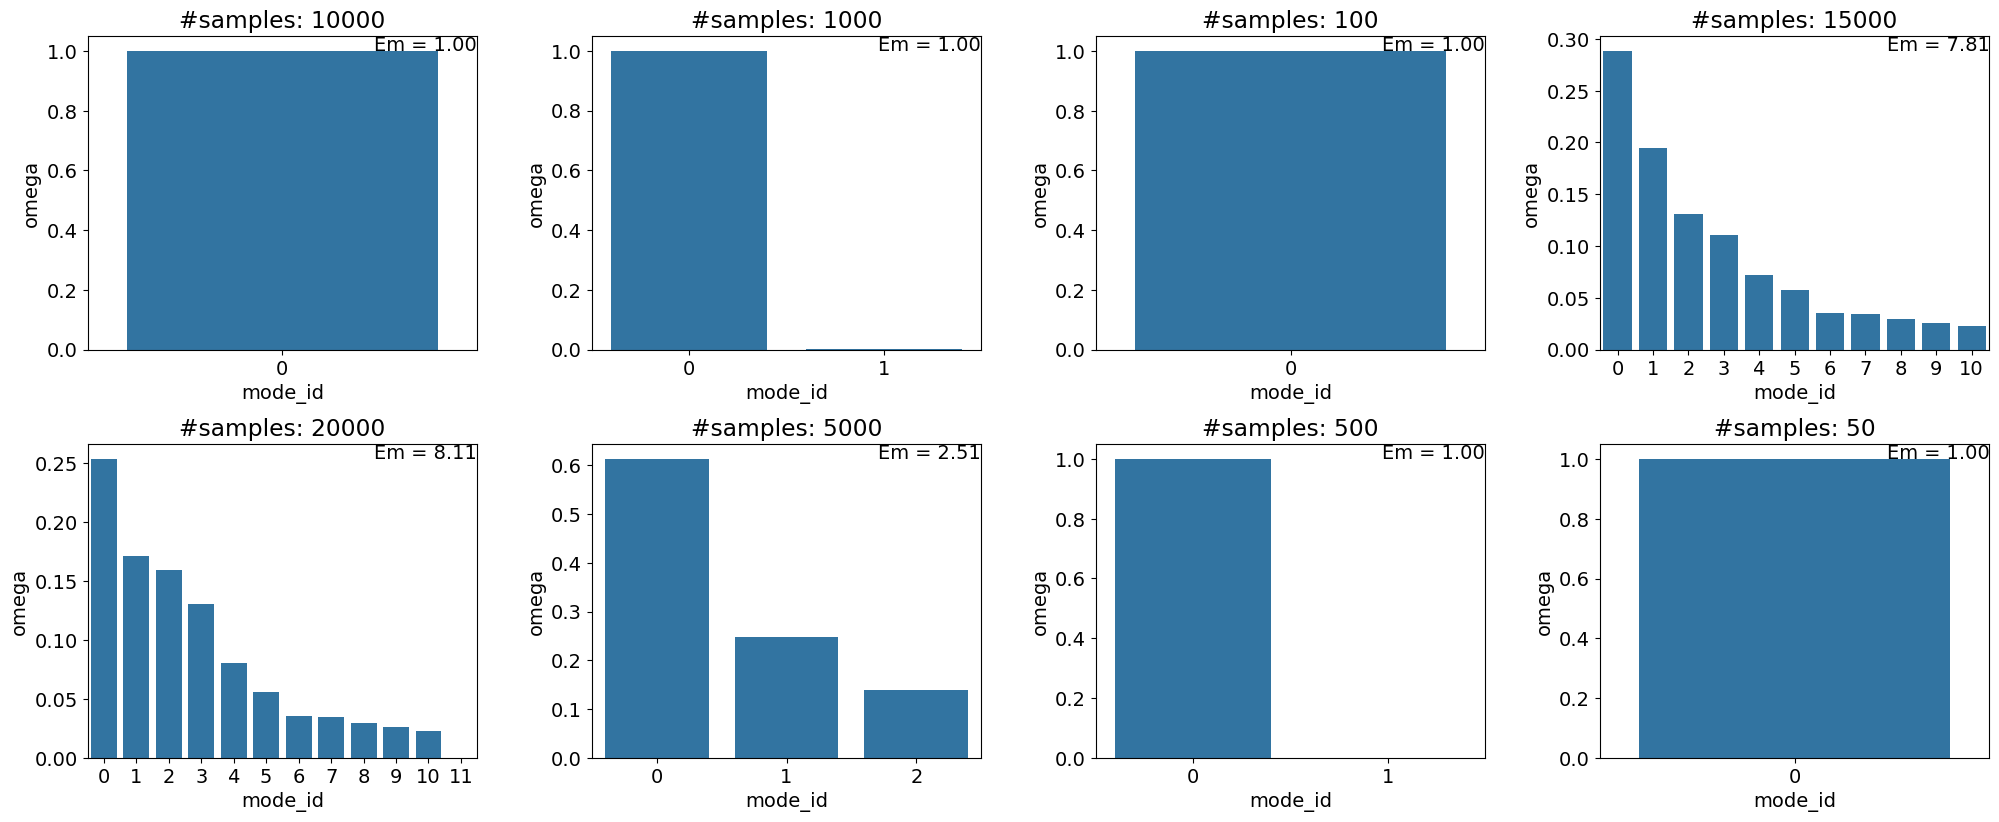

In [18]:
ncols = 4
nrows = int(np.ceil(len(modes_dfs) / ncols))
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 4*nrows))
fig.tight_layout(h_pad=3, w_pad=3)

for idx_df, modes_df in enumerate(modes_dfs):
    r, c = divmod(idx_df, ncols)
    ax = axs[r, c] if nrows > 1 else axs[c]
    samples = modes_df['samples'].unique()[0]
    Em = np.exp(stats.entropy(modes_df['omega']))
    sns.barplot(modes_df, y='omega', x='mode_id', ax=ax)
    ax.text(
        1, 1, f'Em = {Em:.2f}',
        transform=ax.transAxes,  # use axes coordinates (0–1 range)
        ha="right", va="top"     # align right and top
    )
    ax.set(title=f'#samples: {samples}')

In [13]:
modes_df = modes_dfs[3]
modes_df

,samples,sub,sbm,mode_id,mode,pi,omega,sigma
0,15000,SLC01,sbm-nd-h,0,<graph_tool.inference.partition_modes.Partitio...,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.288382,0.015128
1,15000,SLC01,sbm-nd-h,1,<graph_tool.inference.partition_modes.Partitio...,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.194135,0.020607
2,15000,SLC01,sbm-nd-h,2,<graph_tool.inference.partition_modes.Partitio...,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.130507,0.018182
3,15000,SLC01,sbm-nd-h,3,<graph_tool.inference.partition_modes.Partitio...,"[[0.9989151398264223, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.110591,0.031455
4,15000,SLC01,sbm-nd-h,4,<graph_tool.inference.partition_modes.Partitio...,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.072239,0.020640
5,15000,SLC01,sbm-nd-h,5,<graph_tool.inference.partition_modes.Partitio...,"[[0.9995359628770302, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.057455,0.020090
6,15000,SLC01,sbm-nd-h,6,<graph_tool.inference.partition_modes.Partitio...,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.034900,0.026109
7,15000,SLC01,sbm-nd-h,7,<graph_tool.inference.partition_modes.Partitio...,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.034433,0.049946
8,15000,SLC01,sbm-nd-h,8,<graph_tool.inference.partition_modes.Partitio...,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.029141,0.038764
9,15000,SLC01,sbm-nd-h,9,<graph_tool.inference.partition_modes.Partitio...,"[[0.998452810727179, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.025848,0.027016


np.float64(7.812052750612452)